In [5]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
from IPython import display
import os

tf.random.set_seed(42)
np.random.seed(42)

# 创建原始数据集

In [2]:
# 将音频重采样为8000 Hz

# import os
# import librosa
# import soundfile as sf

# def resample_wav_files(input_directory):
#     # 创建新文件夹的路径
#     output_directory = os.path.join(os.path.dirname(input_directory), os.path.basename(input_directory) + '_resample_8000')
#     os.makedirs(output_directory, exist_ok=True)

#     # 遍历文件夹中的所有文件
#     for filename in os.listdir(input_directory):
#         if filename.endswith('.wav'):
#             file_path = os.path.join(input_directory, filename)
#             y, sr = librosa.load(file_path, sr=None)  # 加载原始音频文件，不进行重采样
#             target_sample_rate = 8000
#             y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sample_rate)  # 重采样至8000 Hz
            
#             # 生成重采样后的文件路径
#             new_file_path = os.path.join(output_directory, filename)
            
#             # 保存重采样后的音频文件
#             sf.write(new_file_path, y_resampled, target_sample_rate)

#     print(f"所有音频文件已重采样并保存到 {output_directory}")

# # 调用函数，传入你要处理的文件夹路径
# input_directory = './speech_commands_v0.01.tar/bird'
# resample_wav_files(input_directory)


Found 6923 files belonging to 4 classes.
Using 5539 files for training.
Using 1384 files for validation.
['bed_resample_8000' 'bird_resample_8000' 'cat_resample_8000'
 'dog_resample_8000']

befor: f(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
after: f(TensorSpec(shape=(None, 8000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


C:\Users\li_wa\AppData\Local\Temp\ipykernel_11516\378950449.py:41: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([1, 1])


(TensorSpec(shape=(None, 8000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


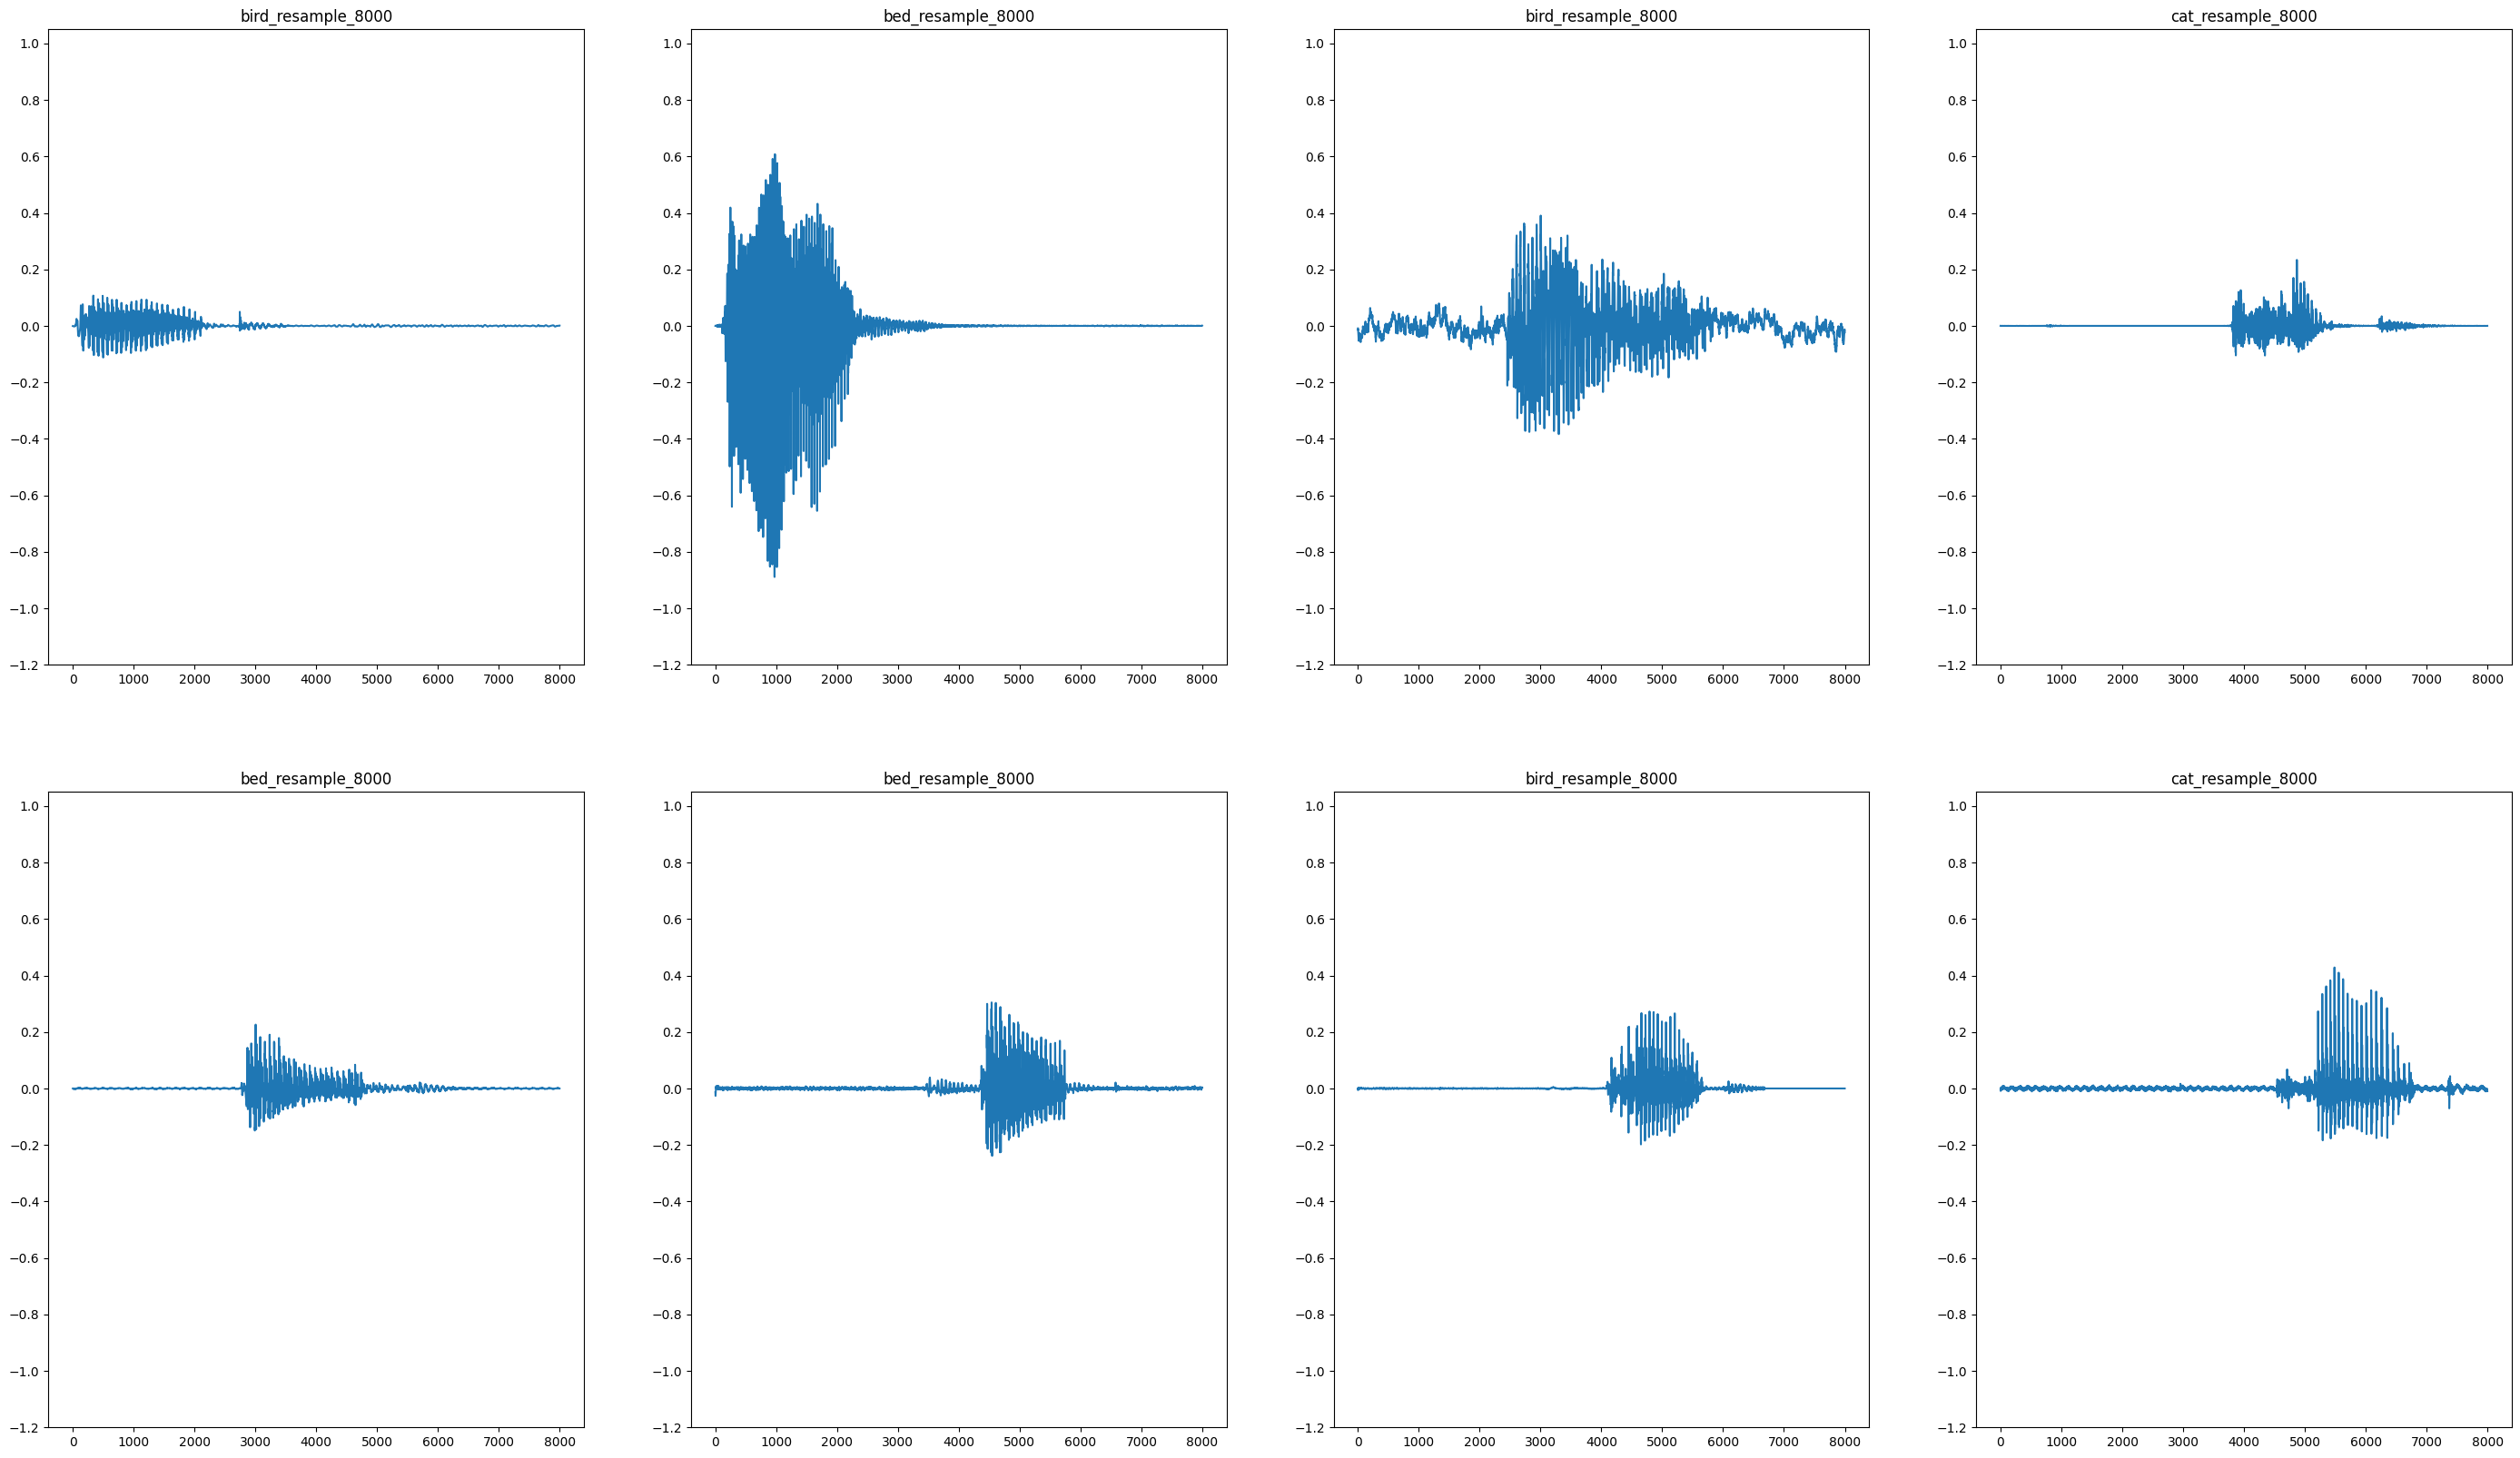

In [6]:
DATASET_PATH = "./speech_commands_v0.01.tar_8000"
data_dir = pathlib.Path(DATASET_PATH)


# 原始数据集
batch_size = 64
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=batch_size,
        validation_split=0.2,
        seed=0,
        output_sequence_length=8000,
        subset="both"

)
# 标签字符串
label_names = np.array(train_ds.class_names)
print(label_names)
# 音频信号降维度(单声道)
print(f"\nbefor: f{train_ds.element_spec}")
def squeeze(audio, label):
        audio = tf.squeeze(audio, axis=-1)
        return audio, label
# map 函数自动将每个元素解包，所以squeeze 的输入变量必须为2 个
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
print(f"after: f{train_ds.element_spec}")

# 细分出验证集和测试集
test_ds = val_ds.shard(num_shards=2, index=1)
val_ds = val_ds.shard(num_shards=2, index=0)

# 遍历数据集
plt.figure(figsize=(35, 20))
for batch in train_ds:
        batch_audio, batch_index = batch
        for i in range(batch_size):
                plt.subplot(2, 4, i+1)
                plt.plot(batch_audio[i])
                plt.title(label_names[batch_index[i]])
                plt.ylim([1, 1])
                plt.yticks(np.arange(-1.2, 1.2, 0.2))
                if i+1 == 8:
                        break
        break

print(train_ds.element_spec)


# 计算需要保留的频率桶索引

In [8]:
def hz_to_mel(frequency_hz):
    mel_scale = 2595 * np.log10(1 + frequency_hz / 700)
    return mel_scale

# Step 1: 生成128个等步长的频率值
frequency_array = np.arange(0, 4000, 4000 / 128)

# Step 2: 将这些频率转换为梅尔频率
mel_frequency_array = np.array([hz_to_mel(f) for f in frequency_array])

# Step 3: 设定步长（以Hz为单位），并基于Hz来选择频率
step_hz = 33.5
critical_value = 0
temp_list = []
for mel_frequency in mel_frequency_array:
    if mel_frequency >= critical_value:
        temp_list.append(mel_frequency)
        critical_value += step_hz

index_list = []
for i in temp_list:
    index_list.append(np.where(np.isclose(i, mel_frequency_array))[0][0])
print(f"筛选出的频率个数：{len(temp_list)}")
print(f"被选择频率的索引：{index_list}")

筛选出的频率个数：64
被选择频率的索引：[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 33, 34, 36, 38, 40, 41, 43, 45, 47, 50, 52, 54, 56, 59, 61, 63, 66, 69, 71, 74, 77, 80, 83, 86, 90, 93, 96, 100, 104, 107, 111, 115, 120, 124]


#  创建频谱图数据集

In [9]:


# 单个音频转频谱图
def wave_to_spetrogram(wave, label):
        # 这里的wave 依旧是个符号张量，不能转换成numpy, 可以直接用tf 的API
        spectrogram = tf.signal.stft(wave, frame_length=256, frame_step=128)
        # 复数转模
        spectrogram = tf.abs(spectrogram)
        
        # 使用梅尔索引减少频率桶
        spectrogram = tf.gather(spectrogram, index_list, axis=2)  # 在频率轴（axis=2）上选择索引
        

        # 增加维度
        spectrogram = spectrogram[..., tf.newaxis]
        return spectrogram, label

train_spectrogram_ds = train_ds.map(wave_to_spetrogram, tf.data.AUTOTUNE)
val_spectrogram_ds = val_ds.map(wave_to_spetrogram, tf.data.AUTOTUNE)
test_spectrogram_ds = test_ds.map(wave_to_spetrogram, tf.data.AUTOTUNE)

print("张量形状：")
print(train_spectrogram_ds.element_spec)



张量形状：
(TensorSpec(shape=(None, 61, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


61 range(0, 64)


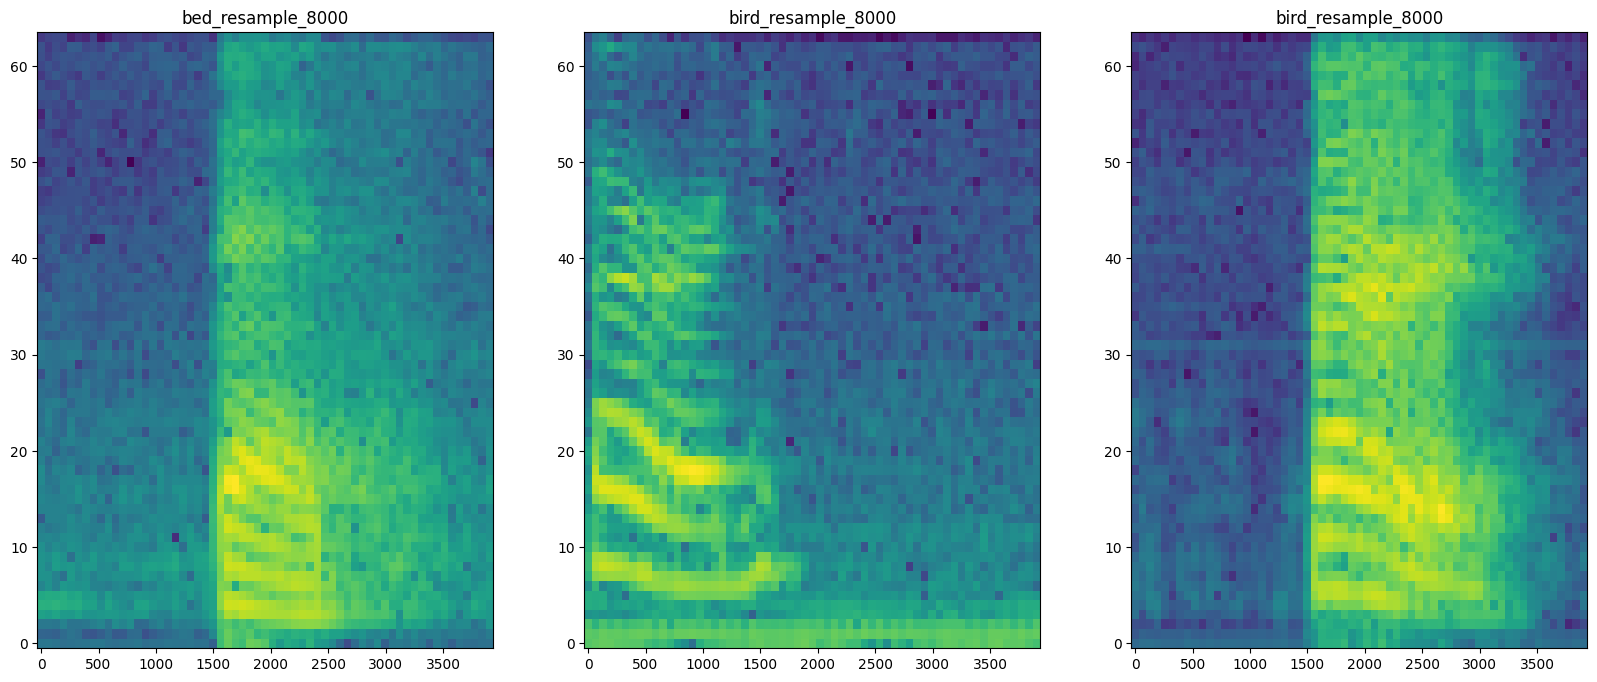

In [10]:
# 画频谱图
plt.figure(figsize=(20, 8))
for batch in train_spectrogram_ds:
        spectrogram_batch, label_batch = batch
        for i in range(batch_size):
                spectrogram = spectrogram_batch[i]
                label_index = label_batch[i]
                spectrogram = np.squeeze(spectrogram, axis=-1)
                log_spec = np.log(spectrogram + np.finfo(float).eps)

                X = np.linspace(0, np.size(spectrogram), num=log_spec.shape[0], dtype=int)
                Y = range(log_spec.shape[1])

                # 这个函数的定义如此, 需要转置
                plt.subplot(1, 3, 1)
                plt.pcolormesh(X, Y, log_spec.T)  
                plt.title(label_names[label_index]) 
          
                break
        break  

for batch in val_spectrogram_ds:
        spectrogram_batch, label_batch = batch
        for i in range(batch_size):
                spectrogram = spectrogram_batch[i]
                label_index = label_batch[i]
                spectrogram = np.squeeze(spectrogram, axis=-1)
                log_spec = np.log(spectrogram + np.finfo(float).eps)

                X = np.linspace(0, np.size(spectrogram), num=log_spec.shape[0], dtype=int)
                Y = range(log_spec.shape[1])

                # 这个函数的定义如此, 需要转置
                plt.subplot(1, 3, 2)
                plt.pcolormesh(X, Y, log_spec.T)  
                plt.title(label_names[label_index])   
          
                break
        break  

for batch in test_spectrogram_ds:
        spectrogram_batch, label_batch = batch
        for i in range(batch_size):
                spectrogram = spectrogram_batch[i]
                label_index = label_batch[i]
                spectrogram = np.squeeze(spectrogram, axis=-1)
                log_spec = np.log(spectrogram + np.finfo(float).eps)

                X = np.linspace(0, np.size(spectrogram), num=log_spec.shape[0], dtype=int)
                Y = range(log_spec.shape[1])

                # 这个函数的定义如此, 需要转置
                plt.subplot(1, 3, 3)
                plt.pcolormesh(X, Y, log_spec.T)  
                plt.title(label_names[label_index])  
                
                print(len(X), Y)
                break
        break  

# 构建模型

In [27]:
for batch in test_spectrogram_ds:
        spectrogram_batch, label_batch = batch
        for i in range(batch_size):
                example_spectrogram = spectrogram_batch[0]
                break
        break


input_shape = example_spectrogram.shape
output_shape = len(label_names)
print(f"input_shape: {input_shape}")
print(f"output_shape: {output_shape}")
        
# 标准化训练数据集，删除标签
# norm_layer = tf.keras.layers.Normalization()
# norm_layer.adapt(data= train_spectrogram_ds.map(map_func=lambda spec, lable: spec))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    
    tf.keras.layers.Resizing(32, 32),
    # # Normalize.
    # norm_layer,
    # 使用较小的卷积核
    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 卷积核从3x3改为2x2
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_shape),
])



model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)],
)

input_shape: (61, 64, 1)
output_shape: 4
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
             

# 运行简单测试

(1, 61, 64, 1)


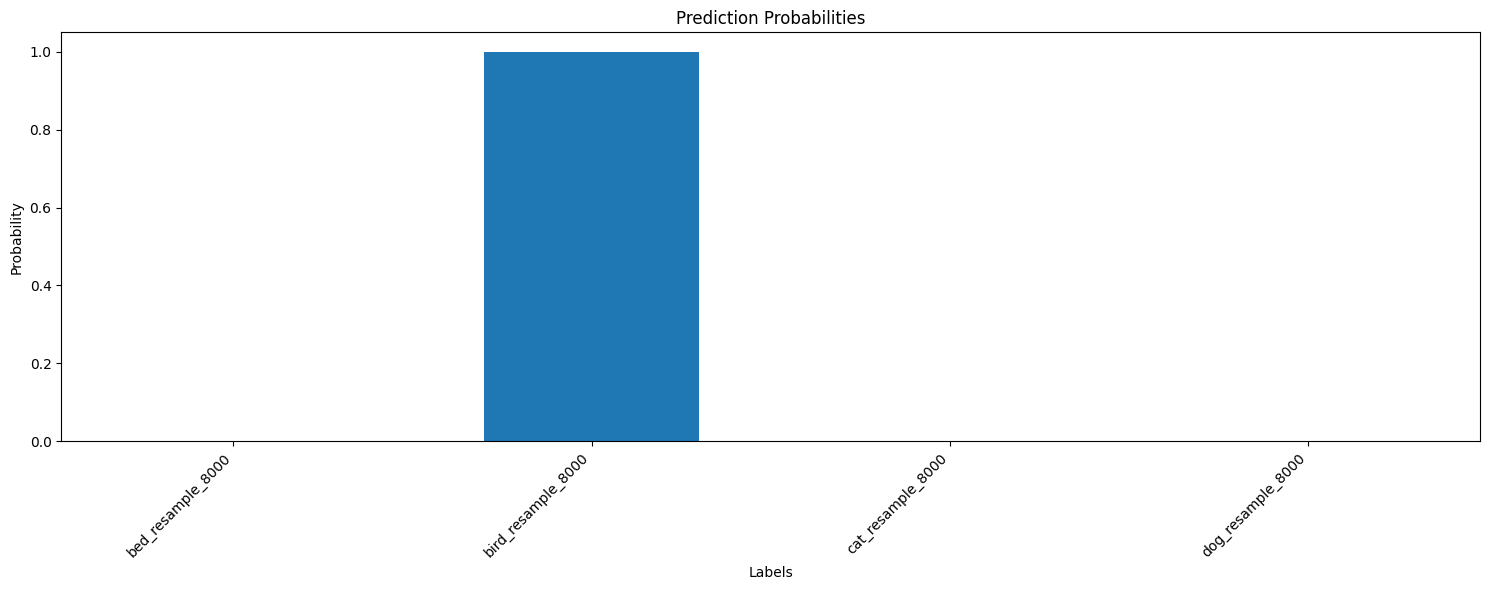

In [19]:
x = './bird_8000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = x[tf.newaxis,...]
x, _= wave_to_spetrogram(x, None)

print(x.shape)

prediction = model(x)

x_labels = label_names
plt.figure(figsize=(15, 6))  # 增加图形的宽度
bar_width = 0.6  # 增加条形的宽度

plt.bar(x_labels, tf.nn.softmax(prediction[0]), width=bar_width)
plt.title('Prediction Probabilities')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.xticks(rotation=45, ha='right')  # 旋转标签以防止重叠
plt.tight_layout()  # 自动调整布局以确保所有元素可见
plt.show()

# 播放音频
display.display(display.Audio(waveform, rate=8000))

# 将模型写入文件

In [28]:
# 文件名
MODEL_NO_ABSTRACT = './MODEL_NO_ABSTRACT_8000'
MODEL_NO_QUANT_TFLITE = './MODEL_NO_QUANT_TFLITE_8000'
MODEL_QUANT_TFLITE = './MODEL_QUANT_TFLITE_8000'

# 未封装的原始模型
tf.saved_model.save(model, MODEL_NO_ABSTRACT)

# 未量化 Lite 模型
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NO_ABSTRACT)
model_no_quant_tflite = converter.convert()
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# 量化后 Lite 模型
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NO_ABSTRACT)
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# 提供量化所需的代表数据集
tensor_list = []
for i in range(10):
        tensor_temp = (list(train_spectrogram_ds)[i][0])
        tensor_list.append(tensor_temp)
# shape:(640, 124, 65, 1)
concatenated_tensor = tf.concat(tensor_list, axis=0)
# 定义生成器函数
def representative_dataset():
        for i in range(500):
                sample = concatenated_tensor[i]
                sample = sample[tf.newaxis, ...]
                yield([sample])
converter.representative_dataset = representative_dataset
# 转化
model_quant_tflite = converter.convert()
# 写入
open(MODEL_QUANT_TFLITE, "wb").write(model_quant_tflite)

INFO:tensorflow:Assets written to: ./MODEL_NO_ABSTRACT_8000\assets


INFO:tensorflow:Assets written to: ./MODEL_NO_ABSTRACT_8000\assets


281064

In [29]:
# 模型大小比较
def getFileSize(filePath, size=0):
    for root, dirs, files in os.walk(filePath):
        for f in files:
            size += os.path.getsize(os.path.join(root, f))
    return size

size_MODEL_NO_ABSTRACT= getFileSize(MODEL_NO_ABSTRACT)
size_MODEL_NO_QUANT_TFLITE = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_MODEL_QUANT_TFLITE = os.path.getsize(MODEL_QUANT_TFLITE)

print(f"size_MODEL_NO_ABSTRACT: {size_MODEL_NO_ABSTRACT}")
print(f"size_MODEL_NO_QUANT_TFLITE: {size_MODEL_NO_QUANT_TFLITE}")
print(f"size_MODEL_QUANT_TFLITE: {size_MODEL_QUANT_TFLITE}")

size_MODEL_NO_ABSTRACT: 3484679
size_MODEL_NO_QUANT_TFLITE: 1095340
size_MODEL_QUANT_TFLITE: 281064


# 模型准确率比较

In [30]:
# 预测效果比较
def evaluate_tflite(tflite_model_path, dataset):
        # 取出测试集
        array_list_spectrogram = []     
        array_list_label = []
        for data, label in dataset:
                array_list_spectrogram.append(data)
                array_list_label.append(label)
        combined_array_spectrogram = np.concatenate(array_list_spectrogram, axis=0)
        combined_array_label = np.concatenate(array_list_label, axis=0)  
        
        # 初始化解释器
        interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        # 给模型分配内存
        interpreter.allocate_tensors()
        # 获取模型输入输出接口
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]

        total_num = 0
        right_num = 0
        for spectrogram_single in combined_array_spectrogram:
                total_num = total_num + 1
                spectrogram_single = spectrogram_single[tf.newaxis, ...]

                # 进行推断, ypred 为概率array
                interpreter.set_tensor(input_details["index"], spectrogram_single)
                interpreter.invoke()
                y_pred = interpreter.get_tensor(output_details["index"])[0]
                # 获取最大概率索引
                category_index = np.where(y_pred == np.max(y_pred))[0][0]
                # 验证推断
                if category_index == combined_array_label[total_num - 1]:
                        right_num += 1
                
        return  right_num/total_num    

def evaluate_normal(tf_model_path, dataset):
        # 取出测试集
        array_list_spectrogram = []     
        array_list_label = []
        for data, label in dataset:
                array_list_spectrogram.append(data)
                array_list_label.append(label)
        combined_array_spectrogram = np.concatenate(array_list_spectrogram, axis=0)
        combined_array_label = np.concatenate(array_list_label, axis=0)

        total_num = 0
        right_num = 0
        # 进行推断
        model = tf.saved_model.load(tf_model_path)
        for spectrogram_single in combined_array_spectrogram:
                total_num += 1

                spectrogram_single = spectrogram_single[tf.newaxis, ...]  
                result_array = model(spectrogram_single).numpy()
                # 结果处理
                result_num = np.max(result_array, axis=1)
                result_index = np.where(result_array == result_num)[1][0]
                # 验证推断
                if result_index == combined_array_label[total_num - 1]:
                        right_num += 1               
                
        return right_num/total_num 

# 文件名
MODEL_NO_ABSTRACT = './MODEL_NO_ABSTRACT_8000'
MODEL_TF = "./MODEL_TF_8000"
MODEL_NO_QUANT_TFLITE = './MODEL_NO_QUANT_TFLITE_8000'
MODEL_QUANT_TFLITE = './MODEL_QUANT_TFLITE_8000'



print("acuracy:\n")

temp = evaluate_normal(MODEL_NO_ABSTRACT, test_spectrogram_ds)
print(f"MODEL_NO_ABSTRACT: {temp}")

temp = evaluate_tflite(MODEL_NO_QUANT_TFLITE, test_spectrogram_ds)
print(f"MODEL_NO_QUANT_TFLITE: {temp}")

temp = evaluate_tflite(MODEL_QUANT_TFLITE, test_spectrogram_ds)
print(f"MODEL_QUANT_TFLITE: {temp}")


acuracy:

MODEL_NO_ABSTRACT: 0.9058823529411765
MODEL_NO_QUANT_TFLITE: 0.9058823529411765
MODEL_QUANT_TFLITE: 0.8632352941176471


# 将模型写成.cc 文件
#### !xxd -i MODEL_QUANT_TFLITE_8000 > MODEL_QUANT_TFLITE_8000.cc
#### !cat MODEL_QUANT_TFLITE_8000.cc

# 临时测试代码

# 导出音频或者频谱图到文件

In [14]:
# 导出所用函数

# 函数将 NumPy 数组转换为 C 语言数组格式
def numpy_to_c_array(np_array, array_name="my_array"):
    # 将 NumPy 数组转化为字符串，使用逗号分隔元素
    array_elements = ", ".join(map(str, np_array))
    
    # 根据 NumPy 数组的大小生成 C 语言数组定义
    c_array = f"const float {array_name}[] = {{{array_elements}}};\n"
    
    return c_array

# 将 NumPy 数组导出为 C 文件
def export_to_c_file(np_array, file_name="output.c", array_name="my_array"):
    c_code = numpy_to_c_array(np_array, array_name)
    
    with open(file_name, 'w') as file:
        # 写入 C 语言数组代码到文件中
        file.write(c_code)
    
    print(f"C 数组已成功导出到文件 {file_name}")




In [15]:
# 导出频谱图

x = './bird_8000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = x[tf.newaxis,...]
x, _= wave_to_spetrogram(x, None)
x = np.squeeze(x, axis = -1)
x = np.squeeze(x, axis = 0)

print(x.shape)

x = np.array(x)
x = x.flatten()

print(x.shape)

export_to_c_file(x, "my_array.c", "my_array")

(61, 64)
(3904,)
C 数组已成功导出到文件 my_array.c


In [16]:
# 导出时域图

x = './bird_8000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)

print(x)

tf.Tensor([0.00393677 0.00750732 0.0065918  ... 0.         0.         0.        ], shape=(8000,), dtype=float32)
